## Домашнее задание 3. Матрично-векторное дифференцирование. Практика.
### __Deadline - 04.10.2024__

## Основная часть (всего 10 баллов)

__Задача 1. (1 балл)__ Для указанного графа вычислений найдите градиент $\nabla_A L, \nabla_b L$ функции потерь $L$ по входным переменным $A,b$ соответственно. Градиент по $x$ считать известным и равным $\nabla_x L$. Рекомендуется использовать алгоритм backpropogation. 

_Замечание_: не обращайте внимание на размерность матрицы $A$, считайте, что она квадратная ($A \in \mathbb{R}^{n \times n}$)

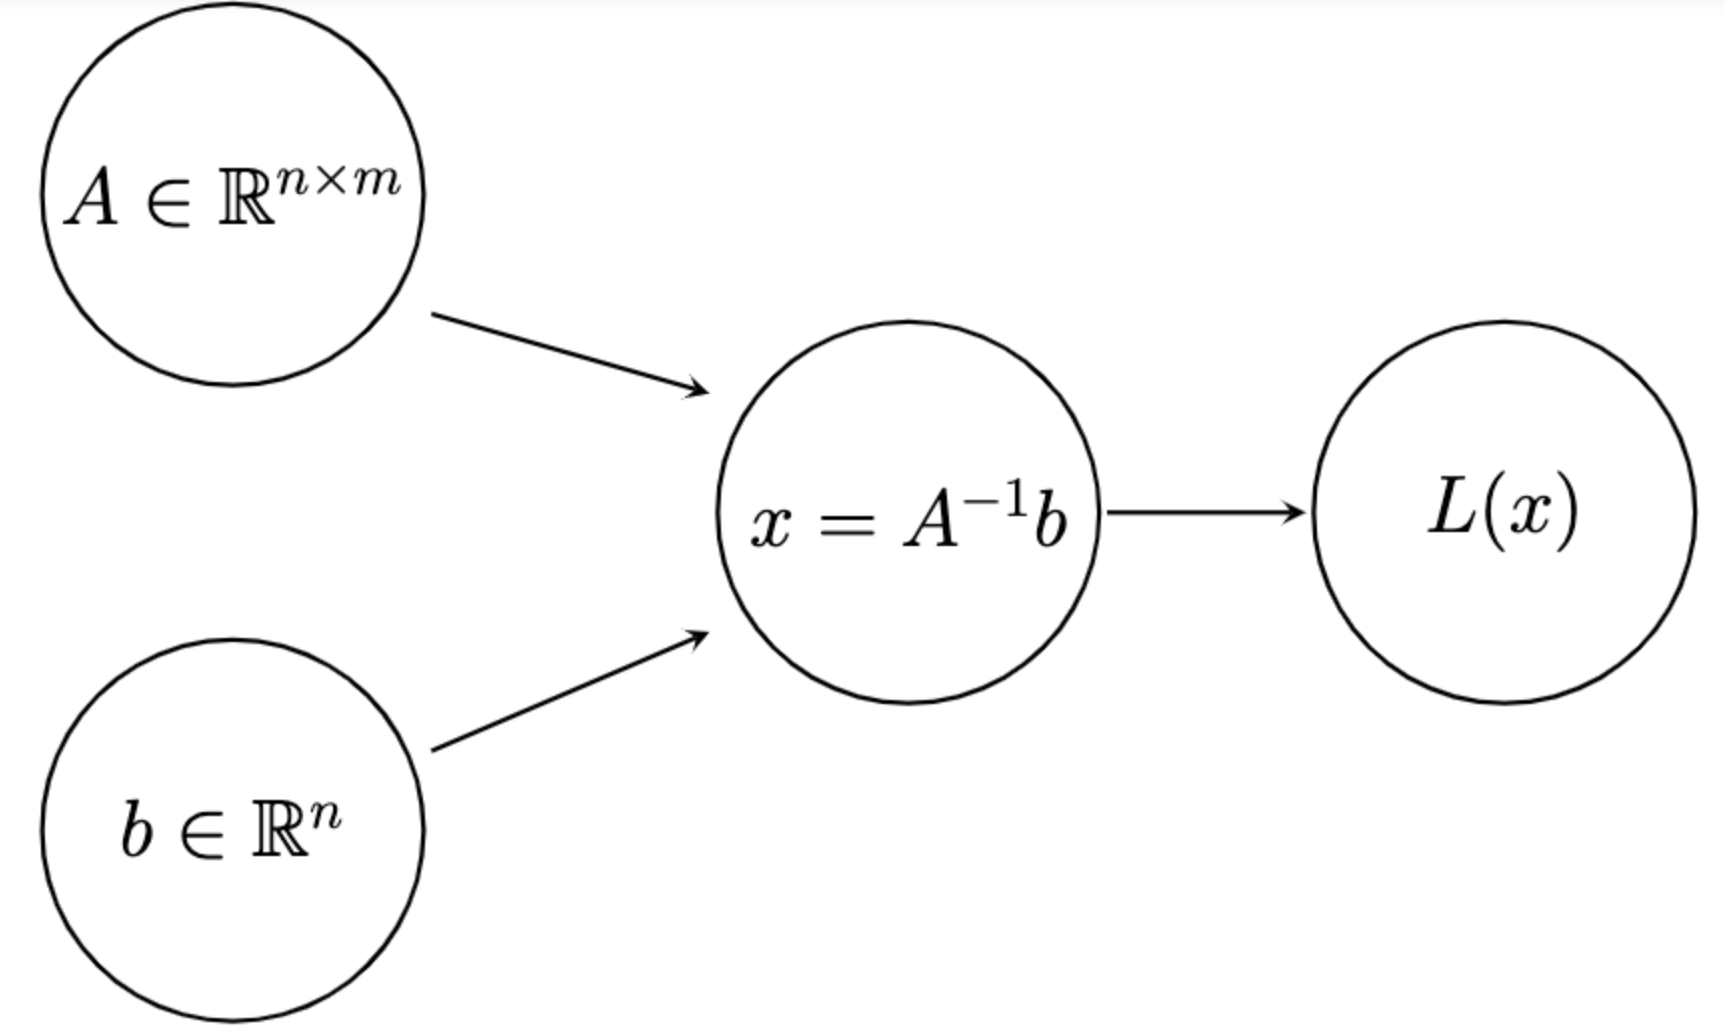

In [1]:
# Ваше решение (Mardown)

__Задача 2.__ Перед Вами стоит задача приближения матрицы $X  \in \mathbb{R}^{N \times M}$ неизвестными матрицами $U \in \mathbb{R}^{R\times N}, V \in \mathbb{R}^{R \times M}$ заданной размерности $R$. Такое приближение часто используется при поиске малоранговых приближений для передачи сжатой информации с минимальными потерями.

В качестве такого приближения предлагается использовать линейное представление $\hat{X} = U^T V$. Для оценки качества приближения будем использовать функцию *MSE*:
$$MSE(X, \hat{X}) = \frac{1}{2}||X - \hat{X} ||^2_F = \frac{1}{2}||X - U^T V||^2_F.$$

__a) (0.5 балла)__  Первым из предложенных методов будет обычный градиентный спуск. Для этого вычислите $\nabla_U MSE, \nabla_V MSE$ и реализуйте функцию ```grad(U, V, X)```, возвращающую значения для вычисленных аналитически градиентов.

Найдем $\nabla_U MSE:$

$\langle \nabla_U (MSE),  H \rangle =  D_U (MSE)[H] = D_U( \frac{1}{2} || X - U^T V ||^{2}_F) [H] = D_U (\frac{1}{2} \langle X - U^T V , X - U^T V \rangle)[H] = $

$ = \langle X - U^TV, D_U (X - U^TV)[H] \rangle = - \langle X - U^TV, H^TV \rangle = - Tr((X - U^TV)^T H^TV) = $

$ = - Tr(H^TV(X - U^TV)^T) = - \langle V(X - U^TV)^T, H \rangle$

Полчаем, что:

$\nabla_U MSE = -V(X - U^TV)^T$


Найдем $\nabla_V MSE:$

$\langle \nabla_V (MSE),  H \rangle =  D_V (MSE)[H] = D_V( \frac{1}{2} || X - U^T V ||^{2}_F) [H] = D_V (\frac{1}{2} \langle X - U^T V , X - U^T V \rangle)[H] = $

$ = \langle X - U^TV, D_V (X - U^TV)[H] \rangle = - \langle X - U^TV, U^TH \rangle = - Tr((X - U^TV)^T U^T H) = $

$ = - Tr((U(X - U^TV))^TH) = - \langle U(X - U^TV), H \rangle$

Полчаем, что:

$\nabla_V MSE = - U(X - U^TV)$

In [2]:
def grad(U, V, X):
    """
    U - матрица размера R*N;
    V - матрица размера R*M;
    X - матрица размера N*M.
    """
    H = X - U.T @ V

    return -V @ H.T, -U @ H

В качестве матрицы $X$ предлагается рассмотреть изображение моста из датасета, созданного для бенчмаркинга различных матричных разложений *`ImageCompressionBenchmark'* (см. прикрепленный файл). Это делается для наглядности результатов, полученных при использовании оптимизационных методов. 

In [3]:
file_name = 'bridge.pgm'

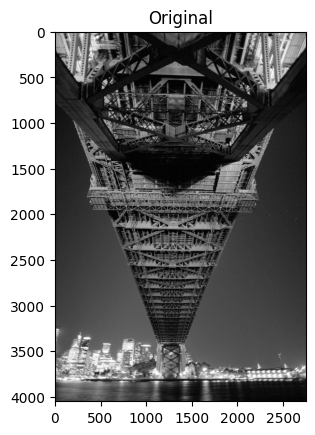

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

X = cv2.imread(file_name, -1)
plt.imshow(X, cmap="gray")
plt.title("Original")
plt.show()
N, M = X.shape

__б) (2 балла)__  Положим ранг $R = 10$. Реализуйте метод градиентного спуска, используя функцию подсчета градиента из предыдущего пункта. В качестве функции критерия используем *MSE*. Также необходимо сделать логгирование полученных значений критерии в зависимости от номера итерации $k$. Для удобства восприятия графиков ошибок, используйте отнормированные значения критерия, т.е.
$$\left(MSE (X, \hat{X}_k) ~/~ MSE (X, \hat{X}_0)\right),$$
где $ \hat{X}_k$ и $ \hat{X}_0$ - значения полученных аппроксимаций на $k$-ой и нулевой итерациях, соответсвенно.

Используйте предложенную функцию для реализации алгоритма и допишите недостающие фрагменты. После чего для проверки загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/).

In [5]:
from tqdm import tqdm


def MatrixGD(grad, criterion, U_0, V_0, X, eps, max_iter, **params):
    """
    grad(U, V, X) - функция, которая считает градиент целевой функции;
    criterion(X, X_k) - функция, которая считает критерий;
    U_0, V_0 - стартовые значения матриц U и V;
    X - матрица, приблежение которой ищем;
    eps - точность сходимости (обычно 1e-3);
    max_iter - количество итераций;
    **params - содержит именнованные гиперпараметры метода:
        params['gamma'](k) - шаг, зависящий от номера итерации;
    """

    errors = []

    X_0 = U_0.T @ V_0

    X_k = np.copy(X_0)
    U = np.copy(U_0)
    V = np.copy(V_0)

    err_x_0 = criterion(X, X_k)
    errors.append(criterion(X, X_k) / err_x_0)

    for k in tqdm(range(max_iter)):

        grad_U, grad_V = grad(U, V, X)

        U -= params["gamma"](k) * grad_U
        V -= params["gamma"](k) * grad_V

        X_k = U.T @ V

        errors.append(criterion(X, X_k) / err_x_0)
        if errors[-1] < eps:
            break

    return X_k, errors

In [6]:
def criterion(X, X_hat):
    H = X - X_hat
    
    return 0.5 * np.linalg.norm(H) ** 2

__в) (1 балл)__ Запустите метод ```MatrixGD``` для сгенерированных стартовых матриц $U_0, V_0$ (функцию ```generate_starting_points``` изменять НЕ НУЖНО). В качестве шага подберите значение из предложенных: $\gamma = \{10^{-6}, 10^{-7}, 10^{-8}\}$.

Постройте график значений критерия от номера итерации. Выведите в виде картинки полученный результат.

In [1]:
import numpy as np

def generate_starting_points(R, N, M):
    np.random.seed(1)

    U = 0.01 * np.random.randn(R, N)
    V = 0.01 * np.random.randn(R, M)
    return U, V

In [8]:
import seaborn as sns

sns.set(style='darkgrid')

$R = 10, \ \gamma = 10^{-8}, \ \varepsilon = 10^{-8}$.

In [9]:
R_10 = 10
gamma = 1e-8
eps = 1e-3

почему $\gamma = 10^{-8}?$

Это связано с тем, что при использовании других значений $\gamma$ у меня постоянно возникали ошибки переполнения: "overflow encountered in matmul" :(

Что, скорее всего, свидетельствует об отсутствии сходимости при данном значении $\gamma$.

Генерируем $U_0, V_0$.

In [10]:
U_0_10, V_0_10 = generate_starting_points(R_10, N, M)

Запустим градиентный спуск.

In [11]:
predicted_X_10, errors_10 = MatrixGD(
    grad=grad,
    criterion=criterion,
    U_0=U_0_10,
    V_0=V_0_10,
    X=X,
    eps=eps,
    max_iter=800,
    gamma=lambda _: 1e-8,
)

100%|██████████| 800/800 [08:05<00:00,  1.65it/s]


Выведем результат.

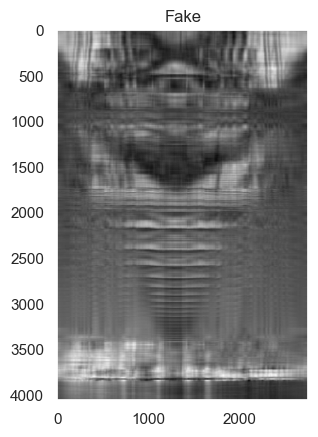

In [12]:
plt.imshow(predicted_X_10, cmap="gray")
plt.title("Fake")
plt.grid(False)
plt.show()

В целом для $R = 10$ результат не плохой.

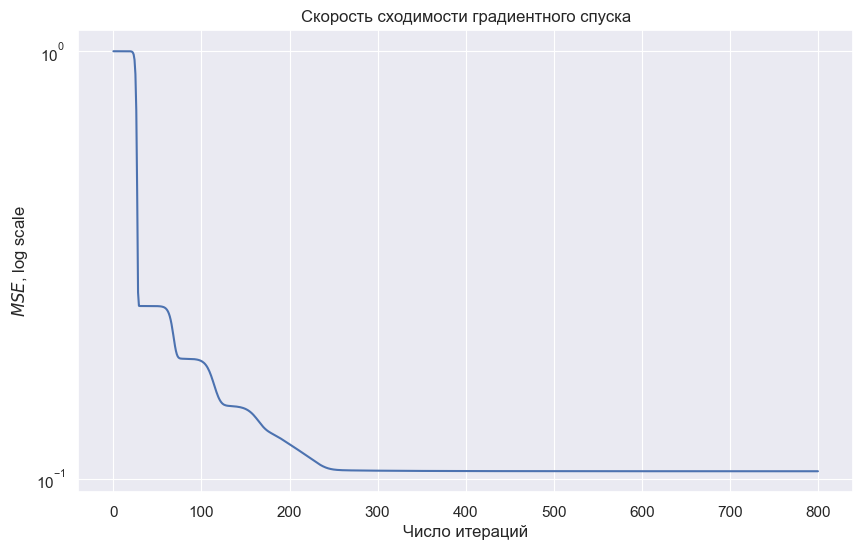

In [40]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=[10, 6])

    plt.plot(errors_10, color="b")

    plt.yscale("log")

    plt.xlabel("Число итераций")
    plt.ylabel(r"$MSE$, log scale")
    plt.title("Скорость сходимости градиентного спуска")

    plt.grid(True, linewidth=0.8)
    plt.show()

Наблюдается резкое снижение MSE в первые 50 итераций, после чего скорость сходимости замедляется. После 100-150 итераций значение MSE начинает стабилизироваться, что указывает на достижение некоего предела точности. Это может означать, что матрицы $U$ и $V$ достигли своего оптимального состояния для данной модели.

__г) (1 балл)__ Следующий этап -- сравнить качество приближений в зависимости от ранга $R$. Рассмотрите следующие значения $R = \{1, 10, 100\}$. Постройте сравнительный график зависимости значения критерия от номера итерации $k$ и выведите в виде картинки полученный результат. Шаг оставьте тот, для которого наблюдалась сходимость в предыдущем пункте. 

In [14]:
R_1 = 1
R_100 = 100

Генерируем $U_0, V_0$ для $R = 1, 100$.

In [15]:
U_0_1, V_0_1 = generate_starting_points(R_1, N, M)
U_0_100, V_0_100 = generate_starting_points(R_100, N, M)

Запустим градиентный спуск для $R = 1, 100$.

In [16]:
# R = 1
predicted_X_1, errors_1 = MatrixGD(
    grad=grad,
    criterion=criterion,
    U_0=U_0_1,
    V_0=V_0_1,
    X=X,
    eps=eps,
    max_iter=800,
    gamma=lambda _: 1e-8,
)

# R = 100
predicted_X_100, errors_100 = MatrixGD(
    grad=grad,
    criterion=criterion,
    U_0=U_0_100,
    V_0=V_0_100,
    X=X,
    eps=eps,
    max_iter=800,
    gamma=lambda _: 1e-8,
)

100%|██████████| 800/800 [09:12<00:00,  1.45it/s]


Выведем результат для всех значении $R$. 

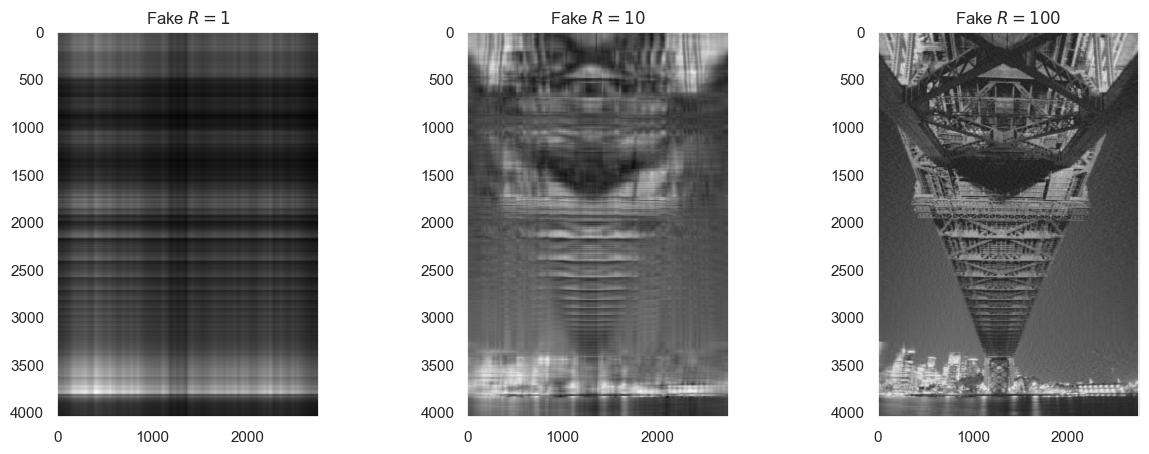

In [17]:
_, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=[15, 5])

ax1.imshow(predicted_X_1, cmap="gray")
ax1.set_title(r"Fake $R = 1$")
ax1.grid(False)

ax2.imshow(predicted_X_10, cmap="gray")
ax2.set_title(r"Fake $R = 10$")
ax2.grid(False)

ax3.imshow(predicted_X_100, cmap="gray")
ax3.set_title(r"Fake $R = 100$")
ax3.grid(False)

plt.show()

- При $R = 1$ качество приближения очень плохая, с низким уровнем детализации, что говорит о том, что приближение низкого ранга захватывает очень мало информации.

- При $R = 10$ качество приближения значительно улучшается, появляются более узнаваемые детали, однако остаются некоторые размытости и потеря мелких деталей.

- При $R = 100$ качество приближения становится гораздо более четкой, что говорит о том, что более высокий ранг захватывает больше деталей.

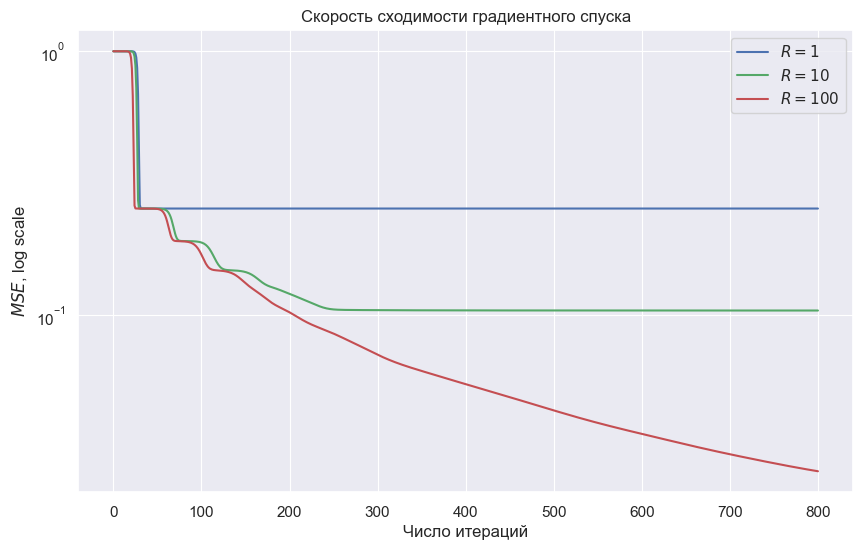

In [18]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=[10, 6])

    plt.plot(errors_1, color="b", label=r"$R = 1$")
    plt.plot(errors_10, color="g", label=r"$R = 10$")
    plt.plot(errors_100, color="r", label=r"$R = 100$")

    plt.yscale("log")

    plt.xlabel("Число итераций")
    plt.ylabel(r"$MSE$, log scale")
    plt.title("Скорость сходимости градиентного спуска")

    plt.grid(True, linewidth=0.8)
    plt.legend()
    plt.show()

Мы наблюдаем, что для каждого значения ранга $R$ существует плато в графиках ошибки, после которого значение критерия (MSE) перестает уменьшаться. Это можно интерпретировать как предел вместимости информации, который может быть представлен с использованием данного ранга.

__Задача 3.__ Теперь, когда вы реализовали метод градиентного спуска для подсчета аппроксимации, перейдем к рассмотрению безградиентного метода AlternatingLeastSquares (ALS) также довольно популярного при работе с восстановлением изображений. На $k$-ой итерации выполняются следующие действия:
1. Для всех $i = 1, \ldots, N$ подсчитать обновление значение матрицы $U$:
$$ U_ki = \left( V_{k - 1} V_{k - 1}^T + \lambda I \right)^{-1} V_{k - 1} X_i $$
2. Для всех $j = 1, \ldots, N$ подсчитать обновление значение матрицы $V$:
$$ V_kj = \left( U_{k} U_{k}^T + \lambda I \right)^{-1} U_{k} X_j^T $$

__а) (2 балла)__ Реализуйте метод ALS c аналогичными требованиями, как и в MatrixGD.

Используйте предложенную функцию для реализации алгоритма и допишите недостающие фрагменты. После чего для проверки загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/).

In [19]:
def ALS(criterion, U_0, V_0, X, eps, max_iter, **params):
    '''
        criterion(X, X_k) - функция, которая считает критерий;
        U_0, V_0 - стартовые значения матриц U и V;
        eps - точность сходимости (обычно 1e-3);
        X - матрица, приблежение которой ищем;
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['lmbda'] - константа для отрешивания задачи поиска обратной матрицы;
    '''

    errors = []
    
    X_0 = U_0.T @ V_0

    X_k = np.copy(X_0)
    U = np.copy(U_0)
    V = np.copy(V_0)
    
    err_x_0 = criterion(X, X_k)
    errors.append(criterion(X, X_k) / err_x_0)

    R = U_0.shape[0]
    
    for k in tqdm(range(max_iter)):

        U = np.linalg.inv(V @ V.T + params["lmbda"] * np.eye(R)) @ V @ X.T
        V = np.linalg.inv(U @ U.T + params["lmbda"] * np.eye(R)) @ U @ X

        X_k = U.T @ V

        errors.append(criterion(X, X_k) / err_x_0)
        if errors[-1] < eps:
            break
            
    return X_k, errors

__б) (1 балл)__ Запустите метод ALS с максимальным числом итераций равным 100, рангом $R$ = 10 и значениями $\lambda = \{1, 10, 100\}$. Постройте сравнительный график значения критерия от номера итерации $k$. Восстановите изображения. Что можно сказать о параметре $\lambda$? Нужен ли он? Если да, то в каких случаях?

In [20]:
R_10 = 10
lmbda = [1, 10, 100]
max_iter = 100

Запустим градиентный спуск для $\lambda = 1, 10, 100$.

In [21]:
ans_10 = [
    ALS(
        criterion=criterion,
        U_0=U_0_10,
        V_0=V_0_10,
        X=X,
        eps=eps,
        max_iter=max_iter,
        lmbda=lmb,
    )
    for lmb in lmbda
]

als_predicted_X_10 = [a[0] for a in ans_10]
als_errors_10 = [a[1] for a in ans_10]

100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Выведем результат для всех значении $\lambda$. 

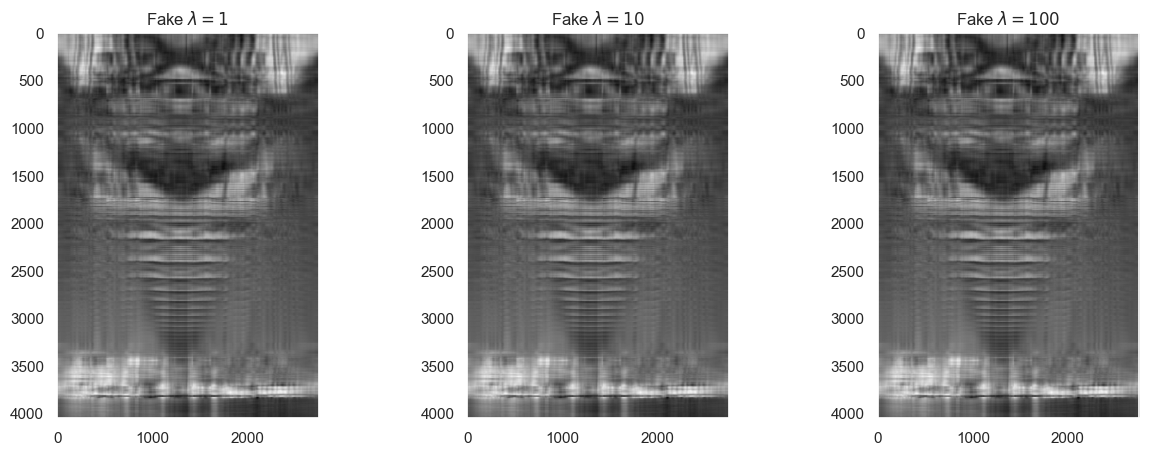

In [22]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 5])


for lmb, ax, predicted_X in zip(lmbda, axs, als_predicted_X_10):
    ax.imshow(predicted_X, cmap="gray")
    ax.set_title(r"Fake $\lambda = " + f"{lmb}$")
    ax.grid(False)

plt.show()

Нет никаких существенных различий.

Также стоит отметить, что полученное изображение очень похоже на картинку, которую мы получили с помощью градиентного спуска для $R = 10$. Похоже мы выжали максимум из этого ранга, то есть достигли наилучшего результата, который можно было получить.

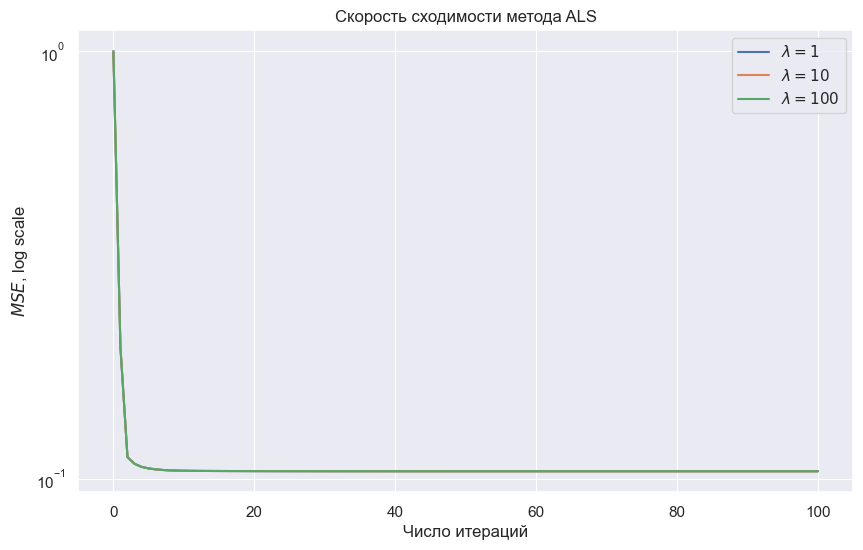

In [23]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=[10, 6])

    for lmb, errors in zip(lmbda, als_errors_10):
        plt.plot(errors, label=r"$\lambda = " + f"{lmb}$")
    
    plt.yscale("log")

    plt.xlabel("Число итераций")
    plt.ylabel(r"$MSE$, log scale")
    plt.title("Скорость сходимости метода ALS")

    plt.grid(True, linewidth=0.8)
    plt.legend()
    plt.show()

Все три графика слились в один, что еще раз подтверждает, что константа $\lambda$ не оказывает влияния на результат.

Также можно отметить, что алгоритму требуется примерно 10-20 итераций, чтобы достичь плато, то есть для сходимости.

__в) (1 балл)__ Как и в предыдущем задании, теперь необходимо сравнить качество приближений в зависимости от ранга $R$. Число итераций поставьте равным 10. Рассмотрите следующие значения $R = \{1, 10, 100\}$. Постройте сравнительный график зависимости значения критерия от номера итерации $k$ и выведите в виде картинки полученный результат. Параметр $\lambda$ выберите на ваше усмотрение.

Так как гиперпараметр $\lambda$ ни на что не влияет, выберем $\lambda = 1$.

In [24]:
lmbda = 1
R = [1, 10, 100]
max_iter = 10

Запустим градиентный спуск для $\lambda = 1  \  R = 1, 10, 100$.

In [25]:
# R = 1
als_predicted_X_1, als_errors_1 = ALS(
    criterion=criterion,
    U_0=U_0_1,
    V_0=V_0_1,
    X=X,
    eps=eps,
    max_iter=max_iter,
    lmbda=lmbda,
)

# R = 10
als_predicted_X_10, als_errors_10 = ALS(
    criterion=criterion,
    U_0=U_0_10,
    V_0=V_0_10,
    X=X,
    eps=eps,
    max_iter=max_iter,
    lmbda=lmbda,
)

# R = 100
als_predicted_X_100, als_errors_100 = ALS(
    criterion=criterion,
    U_0=U_0_100,
    V_0=V_0_100,
    X=X,
    eps=eps,
    max_iter=max_iter,
    lmbda=lmbda,
)

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Выведем результат для всех значении  $R = 1, 10, 100$.

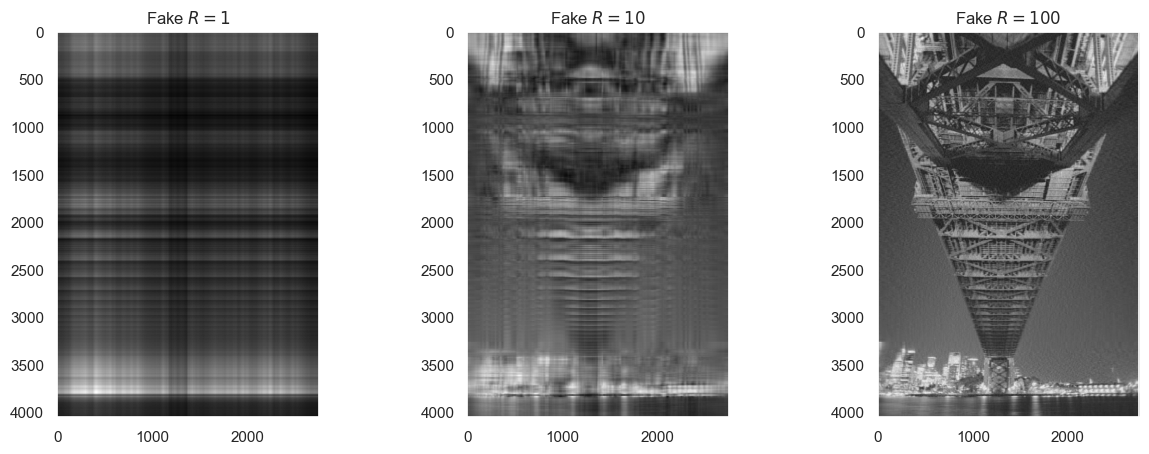

In [26]:
_, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=[15, 5])

ax1.imshow(als_predicted_X_1, cmap="gray")
ax1.set_title(r"Fake $R = 1$")
ax1.grid(False)

ax2.imshow(als_predicted_X_10, cmap="gray")
ax2.set_title(r"Fake $R = 10$")
ax2.grid(False)

ax3.imshow(als_predicted_X_100, cmap="gray")
ax3.set_title(r"Fake $R = 100$")
ax3.grid(False)

plt.show()

Полученные изображения очень похожи на те, которые были получены с помощью градиентного спуска. Можно утверждать, что эти графики представляют собой максимум, которого можно достичь при заданном значении ранга $R$.

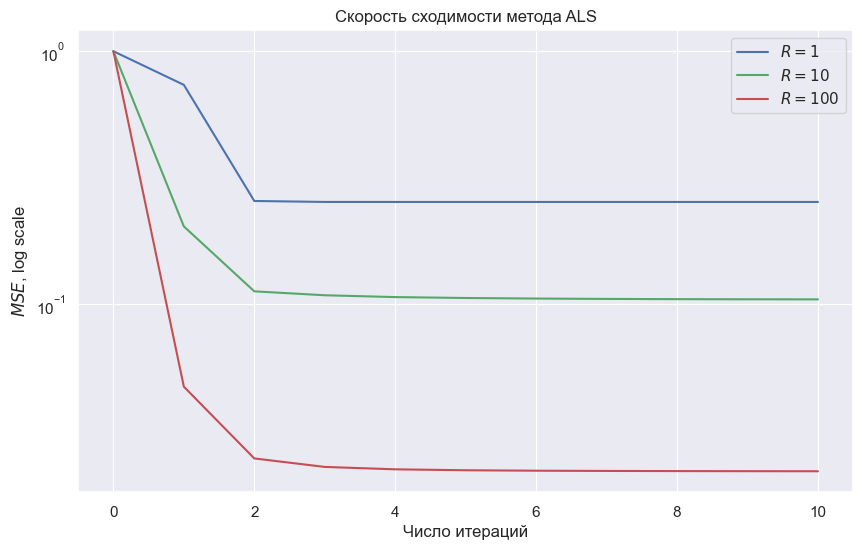

In [27]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=[10, 6])

    plt.plot(als_errors_1, color="b", label=r"$R = 1$")
    plt.plot(als_errors_10, color="g", label=r"$R = 10$")
    plt.plot(als_errors_100, color="r", label=r"$R = 100$")

    plt.yscale("log")

    plt.xlabel("Число итераций")
    plt.ylabel(r"$MSE$, log scale")
    plt.title("Скорость сходимости метода ALS")

    plt.grid(True, linewidth=0.8)
    plt.legend()
    plt.show()

При всех значениях алгоритм ALS быстро достигает плато, причем это плато возникает во всех трех случаях практически одновременно. 

Есть предположение, что алгоритм всегда выполняет несколько итераций, после чего достигает плато.

Проверим это на $R = 1000$.

In [28]:
U_0_1000, V_0_1000 = generate_starting_points(1000, N, M)

# R = 1000
als_predicted_X_1000, als_errors_1000 = ALS(
    criterion=criterion,
    U_0=U_0_1000,
    V_0=V_0_1000,
    X=X,
    eps=1e-8,
    max_iter=max_iter,
    lmbda=lmbda,
)

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


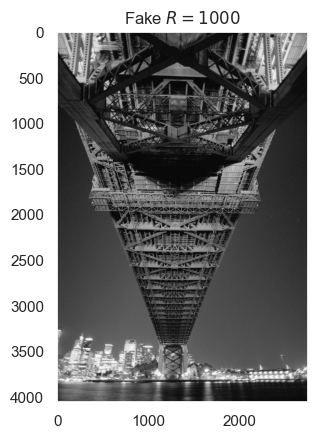

In [29]:
plt.imshow(als_predicted_X_1000, cmap="gray")
plt.title(r"Fake $R = 1000$")
plt.grid(False)
plt.show()

Картину от оригинала уже сложно отличить.

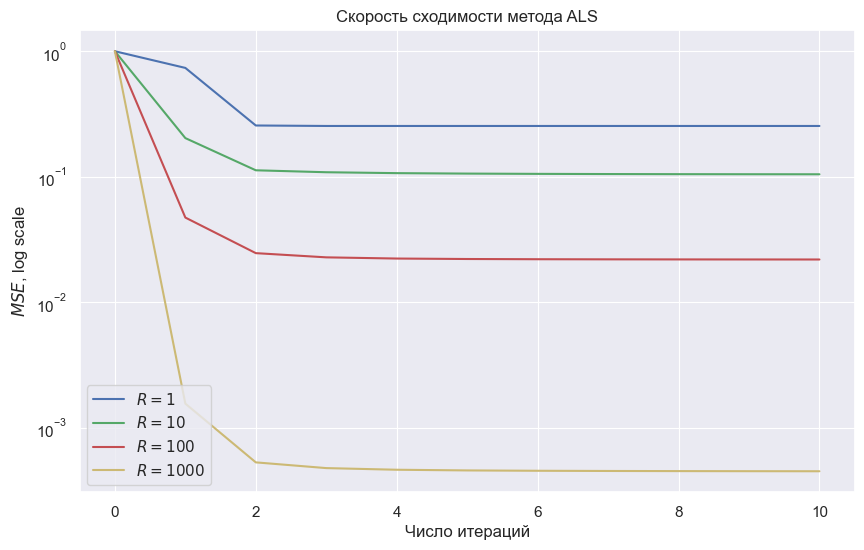

In [30]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=[10, 6])

    plt.plot(als_errors_1, color="b", label=r"$R = 1$")
    plt.plot(als_errors_10, color="g", label=r"$R = 10$")
    plt.plot(als_errors_100, color="r", label=r"$R = 100$")
    plt.plot(als_errors_1000, color="y", label=r"$R = 1000$")

    plt.yscale("log")

    plt.xlabel("Число итераций")
    plt.ylabel(r"$MSE$, log scale")
    plt.title("Скорость сходимости метода ALS")

    plt.grid(True, linewidth=0.8)
    plt.legend()
    plt.show()

Кажется гипотеза правдива.

__г) (0.5 балла)__ Теперь, когда вы познакомились с двумя методами по поиску линейного разложения матрицы в случае фиксированного ранга, сделайте вывод о применимости каждого из них? Есть ли какие-то преимущества у метода ALS в сравнении с MatrixGD? Когда можно применять каждый из них?

In [31]:
print(f"ALS: {np.min(als_errors_1):.4} MatrixGD: {np.min(errors_1):.4}")
print(f"ALS: {np.min(als_errors_10):.4}  MatrixGD: {np.min(errors_10):.4}")
print(f"ALS: {np.min(als_errors_100):.4} MatrixGD: {np.min(errors_100):.4}")

ALS: 0.2538 MatrixGD: 0.2538
ALS: 0.1046  MatrixGD: 0.1043
ALS: 0.0219 MatrixGD: 0.0257


У градиентного спуска, значение ошибки такие же как у метода ALS.

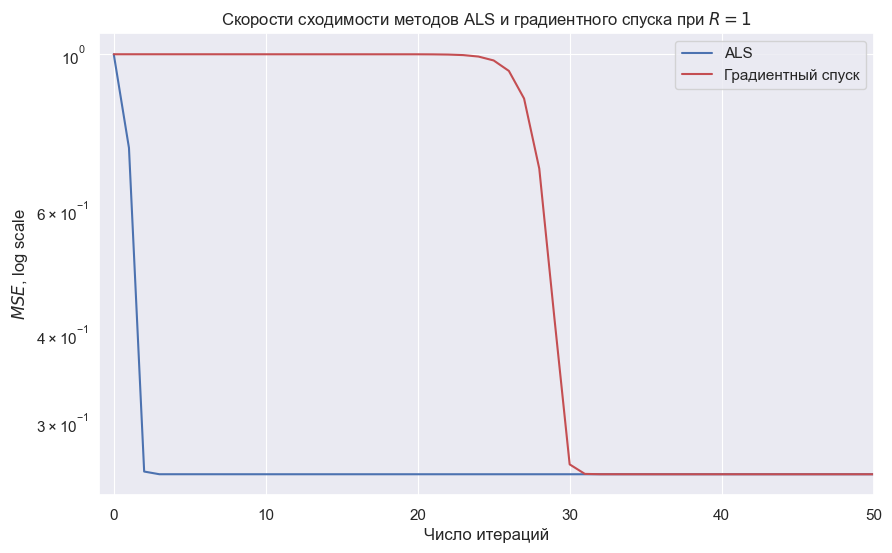

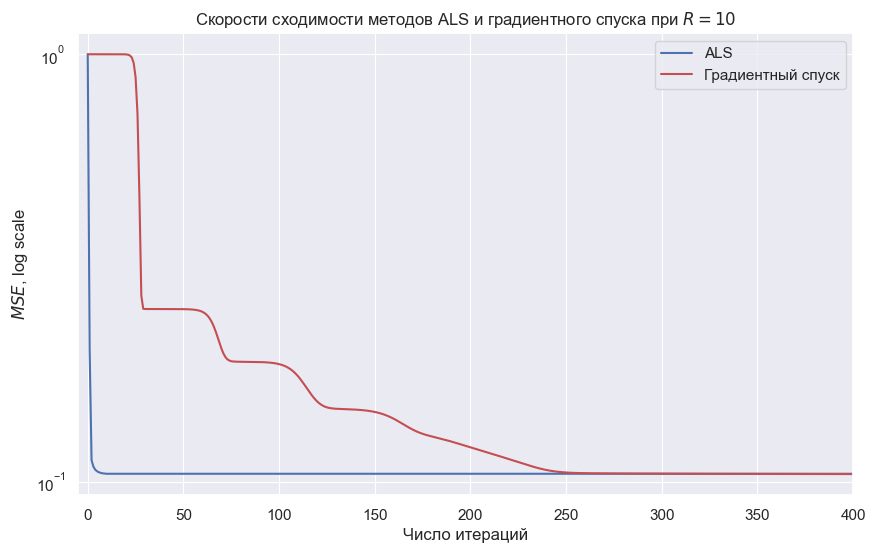

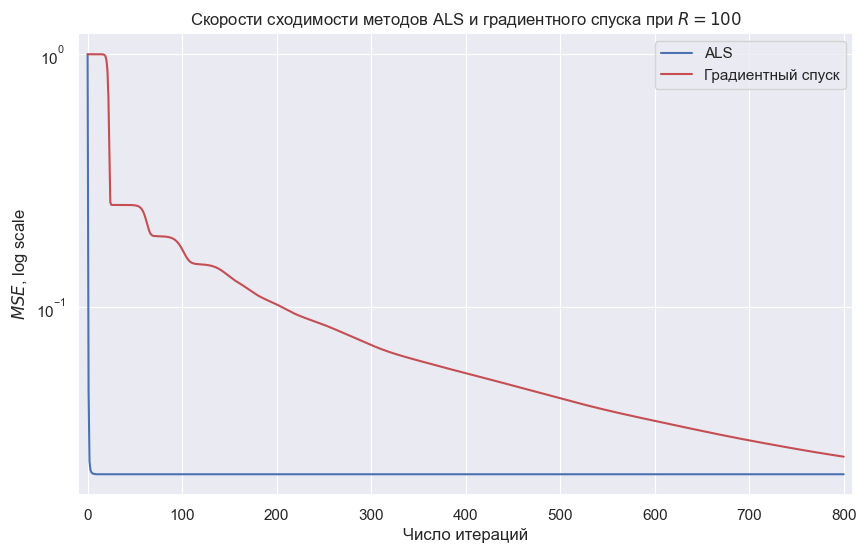

In [59]:
als_errors_1 = list(als_errors_1) + [np.min(als_errors_1) for _ in range(790)]
als_errors_10 = list(als_errors_10) + [np.min(als_errors_10) for _ in range(790)]
als_errors_100 = list(als_errors_100) + [np.min(als_errors_100) for _ in range(790)]

with sns.axes_style("darkgrid"):

    for xlim, R, als_errors, gd_errors in zip(
        [(-1, 50), (-5, 400), (-10, 810)],
        [1, 10, 100],
        [als_errors_1, als_errors_10, als_errors_100],
        [errors_1, errors_10, errors_100],
    ):
        plt.figure(figsize=[10, 6])

        plt.title(
            r"Скорости сходимости методов ALS и градиентного спуска при $R = " f"{R}$"
        )

        plt.plot(als_errors, color="b", label="ALS")
        plt.plot(gd_errors, color="r", label="Градиентный спуск")

        plt.xlim(xlim)

        plt.legend()
        plt.yscale("log")

        plt.xlabel("Число итераций")
        plt.ylabel(r"$MSE$, log scale")

        plt.grid(True, linewidth=0.8)
        plt.show()


В целом по графикам можно сказать, что метод ALS превосходит метод градиентного спуска по скорости сходимости.

- Используйте `ALS` если необходимо быстро получить решение, приемлемое решение.

- Используйте `MatrixGD` если задача имеет сложные или изменяющиеся функции потерь, где можно воспользоваться преимуществами адаптивного шага.

## Реализация backpropagation

Этот часть относится к курсу Practical DL Школы анализа данных Яндекса.

## Дополнительная часть (всего 10 баллов)

__Задача 4.__ Как было рассказано на лекциях и семинарах, для поиска ошибки в машинном обучении строится граф вычислений на основе метода _backpropagation_. В данной части вам будет представлена возможность самостоятельно реализовать различные модули, используемые в нейронных сетях. Для начала представим универсальных класс ```Module```, который определит фундаментальные методы для обучения (в нем НЕ НУЖНО ничего менять). 

Первым является __forward pass__ -- модуль получает входные данные, как-то их обрабатывает, а после выдает полученный результат, т.е.
$$\text{output = module.forward(input)}$$
Вторым же, как несложно догадаться, является __backward pass__ -- по цепному правилу (chain rule) прокидывается градиент от последнего слоя к первому, т.е. 
$$\text{gradInput = module.backward(input, gradOutput)}$$

In [60]:
class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input):
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input):
        pass

    def updateGradInput(self, input, gradOutput):        
        pass   
    
    def accGradParameters(self, input, gradOutput):
        pass
    
    def zeroGradParameters(self): 
        pass
        
    def getParameters(self):
        return []
        
    def getGradParameters(self):
        return []
    
    def train(self):
        self.training = True
    
    def evaluate(self):
        self.training = False
    
    def __repr__(self):
        return "Module"

__а) (2 балла)__ Реализуйте класс ```Sequential```, определяющий контейнер для последовательной обработки модулей (уровней). 

In [61]:
class Sequential(Module):
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        '''
            В данной функции нужно реализовать
            последовательную передачу данных в
            forward pass, используя в качестве 
            входа в новом уровне выход со старого.
        '''

        # Ваше решение

        return self.output

    def backward(self, input, gradOutput):
        '''
            Здесь нужно реализовать последовательную
            передачу градиента по цепному правилу.
            ВАЖНО: убедитесь в том, что при подсчете 
            k-го градиента на вход подается output module[k-1],
            а не его input.  

            g_k = module[k].backward(module[k - 1].output, g_{k + 1})
        '''
        
        # Ваше решение
        
        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()

__б) (2 балла)__ Теперь реализуйте линейный слой (также известный как _dense layer, fully-connected layer, FC-layer_). Он работает с 2D входными даннами размера (n_samples, n_feature). Так как обычно данные передаются в виде батча, то вход и выход могут быть записаны так:
- input:   `batch_size x n_feature_1`
- output: `batch_size x n_feature_2`

In [35]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        # Ваше решение
        # self.output = ...
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Ваше решение
        # self.gradInput = ...
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        # Ваше решение
        # self.gradW = ... ; self.gradb = ...
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

__в) (2 балла)__ Следующим будет нужно реализовать SoftMax слой, преобразующий полученные значения в аналог вероятности. Напомним, что функция softmax может быть определена следующим образом:
$$\text{softmax(x)}_i = \frac{\exp x_i}{\sum \limits_{j} \exp x_j}. $$

_Указание:_ чтобы избежать нестабильности в вычислении экспоненты от большого числа, используется следующее свойство: 
$$\text{softmax(x)} = \text{softmax(x - const)}$$

In [36]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Ваше решение

        return self.output
    
    def updateGradInput(self, input, gradOutput):

        # Ваше решение
        
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

__г) (2 балла)__ Ну и как же без функции активации, которая добавляет нелинейность в нейронную сеть. Рассмотрим самую популярную -- Leaky ReLU ([Leaky Rectified Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLUs)). Поэкспериментируйте со значением коэфциента наклона slope. 

In [37]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, input):

        # Ваше решение
        
        return  self.output
    
    def updateGradInput(self, input, gradOutput):

        # Ваше решение

        return self.gradInput
    
    def __repr__(self):
        return "LeakyReLU"

__д) (2 балла)__ Последний этап -- добавление критерия (функции потерь). Так как с MSE вы познакомились в основной части работы, то теперь к рассмотрению будет предложена ClassNLLCriterion. Он должен реализовывать [multiclass log loss](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Несмотря на то, что в этой формуле есть сумма по __y__ (target), помните, что target-ы кодируются с помощью one-hot encoder. Этот факт значительно упрощает вычисления. Обратите внимание, что критерии - единственное место, где вы делите на размер батча. Также есть небольшой хак с добавлением небольшого числа к вероятности, чтобы избежать вычисления log(0).
- input:   `batch_size x n_feats` - вероятности
- target: `batch_size x n_feats` - one-hot representation
- output: число

In [38]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        return self.output

    def updateGradInput(self, input, target):
        return self.gradInput   

    def __repr__(self):
        return "Criterion"


class ClassNLLCriterion(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        
        # Ваше решение

        return self.output

    def updateGradInput(self, input, target):
        
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        
        # Ваше решение

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

### Тесты 

Для вашего удобства проверки своих реализаций мы добавили автоматические тесты для каждого из реализованных классов.

In [1]:
import torch
import numpy as np
import unittest
import sys

class TestLayers(unittest.TestCase):
    def test_Linear(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in, n_out = 2, 3, 4
        for _ in range(100):
            
            # Инициализация слоев
            torch_layer = torch.nn.Linear(n_in, n_out)
            custom_layer = Linear(n_in, n_out)
            custom_layer.W = torch_layer.weight.data.numpy()
            custom_layer.b = torch_layer.bias.data.numpy()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-10, 10, (batch_size, n_out)).astype(np.float32)

            # 1. Проверка выхода слоя
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))
        
            # 2. Проверка градиента входа
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

            # 3. Проверка градиентов параметров
            custom_layer.accGradParameters(layer_input, next_layer_grad)
            weight_grad = custom_layer.gradW
            bias_grad = custom_layer.gradb
            torch_weight_grad = torch_layer.weight.grad.data.numpy()
            torch_bias_grad = torch_layer.bias.grad.data.numpy()
            self.assertTrue(np.allclose(torch_weight_grad, weight_grad, atol=1e-6))
            self.assertTrue(np.allclose(torch_bias_grad, bias_grad, atol=1e-6))

    def test_SoftMax(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            
            # Инициализация слоев
            torch_layer = torch.nn.Softmax(dim=1)
            custom_layer = SoftMax()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.random((batch_size, n_in)).astype(np.float32)
            next_layer_grad /= next_layer_grad.sum(axis=-1, keepdims=True)
            next_layer_grad = next_layer_grad.clip(1e-5,1.)
            next_layer_grad = 1. / next_layer_grad

            # 1. Проверка выхода слоя
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-5))

            # 2. Проверка градиента входа
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))
            
    def test_LeakyReLU(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            
            # Инициализация слоев
            slope = np.random.uniform(0.01, 0.05)
            torch_layer = torch.nn.LeakyReLU(slope)
            custom_layer = LeakyReLU(slope)

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. Проверка выхода слоя
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. Проверка градиента входа
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_ClassNLLCriterion(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            
            # Инициализация слоев
            torch_layer = torch.nn.NLLLoss()
            custom_layer = ClassNLLCriterion()

            layer_input = np.random.uniform(0, 1, (batch_size, n_in)).astype(np.float32)
            layer_input /= layer_input.sum(axis=-1, keepdims=True)
            layer_input = layer_input.clip(custom_layer.EPS, 1. - custom_layer.EPS)
            target_labels = np.random.choice(n_in, batch_size)
            target = np.zeros((batch_size, n_in), np.float32)
            target[np.arange(batch_size), target_labels] = 1

            # 1. Проверка выхода слоя
            custom_layer_output = custom_layer.updateOutput(layer_input, target)
            layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)

            torch_layer_output_var = torch_layer(
                torch.log(layer_input_var),
                torch.from_numpy(target_labels).to(torch.long))
            
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. Проверка градиента входа
            custom_layer_grad = custom_layer.updateGradInput(layer_input, target)
            torch_layer_output_var.backward()
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))
    
suite = unittest.TestLoader().loadTestsFromTestCase(TestLayers)
unittest.TextTestRunner(verbosity=2).run(suite)

test_ClassNLLCriterion (__main__.TestLayers) ... ERROR
test_LeakyReLU (__main__.TestLayers) ... ERROR
test_Linear (__main__.TestLayers) ... ERROR
test_SoftMax (__main__.TestLayers) ... ERROR

ERROR: test_ClassNLLCriterion (__main__.TestLayers)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_71949/1481249450.py", line 109, in test_ClassNLLCriterion
    custom_layer = ClassNLLCriterion()
NameError: name 'ClassNLLCriterion' is not defined

ERROR: test_LeakyReLU (__main__.TestLayers)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_71949/1481249450.py", line 83, in test_LeakyReLU
    custom_layer = LeakyReLU(slope)
NameError: name 'LeakyReLU' is not defined

ERROR: test_Linear (__main__.TestLayers)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_71949/

<unittest.runner.TextTestResult run=4 errors=4 failures=0>